In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dropout, Dense, Flatten, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.efficientnet_v2 import EfficientNetV2M
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-06-02 13:04:18.110781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip 'NewDataNew.zip'

In [2]:
base_dir = 'mydata'

In [3]:
#Eksplor the dataset
import os
for dirpath, dirnames, filenames in os.walk(base_dir):
  print(f'Ada {len(dirnames)} directori dan {len(filenames)} gambar dalam {dirpath}')

Ada 3 directori dan 0 gambar dalam mydata
Ada 2 directori dan 0 gambar dalam mydata/test
Ada 0 directori dan 32 gambar dalam mydata/test/fresh
Ada 0 directori dan 68 gambar dalam mydata/test/spoiled
Ada 2 directori dan 0 gambar dalam mydata/valid
Ada 0 directori dan 253 gambar dalam mydata/valid/fresh
Ada 0 directori dan 247 gambar dalam mydata/valid/spoiled
Ada 2 directori dan 0 gambar dalam mydata/train
Ada 0 directori dan 1017 gambar dalam mydata/train/fresh
Ada 0 directori dan 927 gambar dalam mydata/train/spoiled


In [4]:
#define batch size and set size of images
batch_size = 32
image_size = (224, 224)

#path of dataset
train_dir = os.path.join(base_dir + '/train')
valid_dir = os.path.join(base_dir + '/valid')
test_dir = os.path.join(base_dir + '/test')

#image generator
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

Found 1944 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


2023-06-02 13:04:31.954453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 13:04:31.955021: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


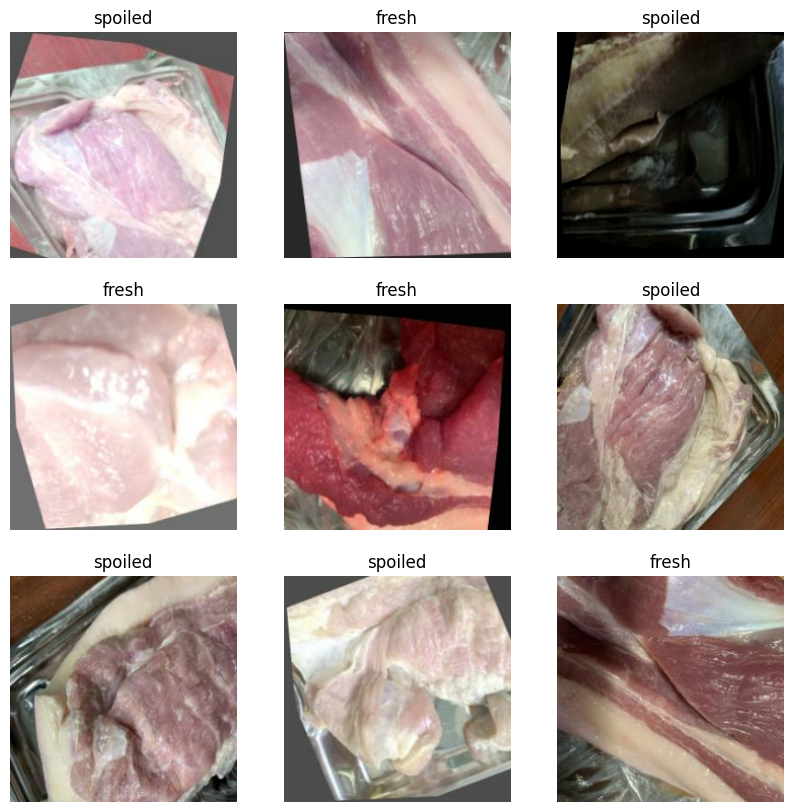

In [5]:
#show train images samples

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
#Optimising input pipeline performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# preprocess input images before feeding them into the MobileNetV2 mode
prep_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale the image values
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
image_shape = image_size + (3,) #represents the number of color channels (RGB) in the image.

#create base model using MobileNetV2, activation softmax
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=2,
                                               classifier_activation="softmax")

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [9]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
#add
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
from keras.layers import BatchNormalization
from keras import Model

inputs = base_model.input
#inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='new_layer_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', name = 'new_layer_2')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', name='new_layer_3')(x)

prediction_layer = Dense(2, activation='softmax', name = 'predictions')(x)

outputs = prediction_layer
model = tf.keras.Model(inputs, outputs)

In [12]:
#Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [13]:
#Evaluate the model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(valid_dataset)

16/16 [==============================] - 4s 237ms/step - loss: 0.7060 - accuracy: 0.5700


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.57


In [15]:
#Train the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
61/61 [==============================] - 21s 326ms/step - loss: 0.4474 - accuracy: 0.7942 - val_loss: 0.1688 - val_accuracy: 0.9400
Epoch 2/10
61/61 [==============================] - 20s 320ms/step - loss: 0.2610 - accuracy: 0.9048 - val_loss: 0.1758 - val_accuracy: 0.9260
Epoch 3/10
61/61 [==============================] - 20s 322ms/step - loss: 0.1994 - accuracy: 0.9285 - val_loss: 0.1035 - val_accuracy: 0.9640
Epoch 4/10
61/61 [==============================] - 20s 321ms/step - loss: 0.1538 - accuracy: 0.9527 - val_loss: 0.1305 - val_accuracy: 0.9480
Epoch 5/10
61/61 [==============================] - 20s 323ms/step - loss: 0.1027 - accuracy: 0.9733 - val_loss: 0.0754 - val_accuracy: 0.9700
Epoch 6/10
61/61 [==============================] - 20s 322ms/step - loss: 0.0784 - accuracy: 0.9846 - val_loss: 0.0695 - val_accuracy: 0.9740
Epoch 7/10
61/61 [==============================] - 20s 326ms/step - loss: 0.0606 - accuracy: 0.9856 - val_loss: 0.0752 - val_accuracy: 0.9680

In [ ]:
model.save('modelwithlayer.h5')

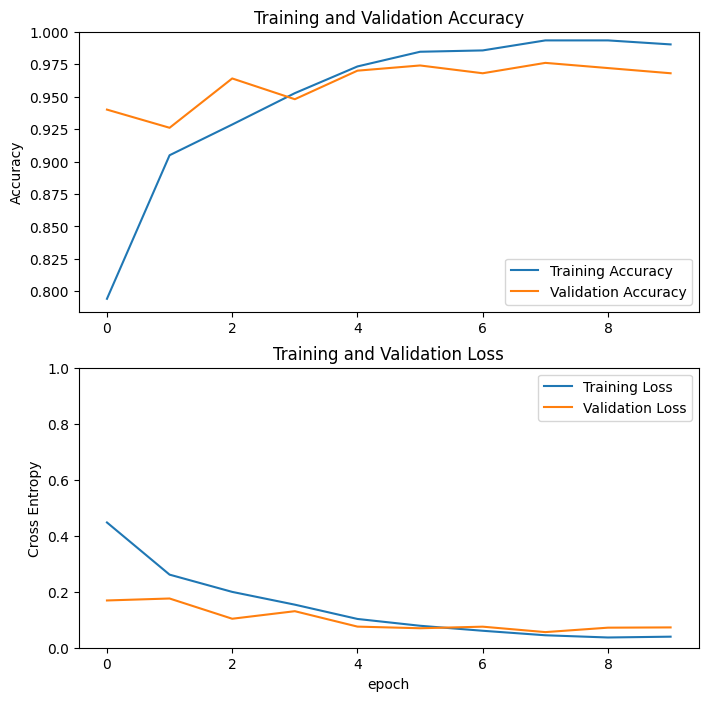

In [16]:
#plot the training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Add Fine Tuning For Model

In [17]:
base_model.trainable = True

ft_at = 80
#freeze the layers before 100 layer
for layer in base_model.layers[:-1]:
  layer.trainable = False

In [18]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
#Re train model after use fine tune
new_epochs = 20
total =  initial_epochs + new_epochs
hist_fine = model.fit(train_dataset,
                         epochs=total,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 10/30
61/61 [==============================] - 22s 336ms/step - loss: 0.0236 - accuracy: 0.9985 - val_loss: 0.0532 - val_accuracy: 0.9760
Epoch 11/30
61/61 [==============================] - 20s 328ms/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 0.0545 - val_accuracy: 0.9780
Epoch 12/30
61/61 [==============================] - 20s 333ms/step - loss: 0.0192 - accuracy: 0.9974 - val_loss: 0.0527 - val_accuracy: 0.9800
Epoch 13/30
61/61 [==============================] - 20s 329ms/step - loss: 0.0162 - accuracy: 0.9985 - val_loss: 0.0495 - val_accuracy: 0.9820
Epoch 14/30
61/61 [==============================] - 20s 331ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9800
Epoch 15/30
61/61 [==============================] - 20s 327ms/step - loss: 0.0114 - accuracy: 0.9995 - val_loss: 0.0509 - val_accuracy: 0.9780
Epoch 16/30
61/61 [==============================] - 20s 327ms/step - loss: 0.0145 - accuracy: 0.9979 - val_loss: 0.0537 - val_accuracy:

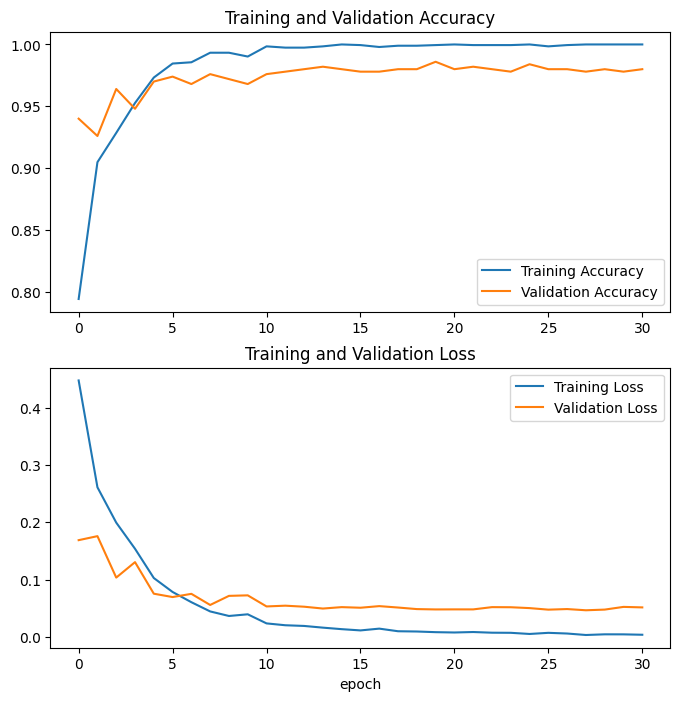

In [21]:
#Let see training result plot after add finetunning
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
#evaluate the model after finetunning
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 187ms/step - loss: 0.1591 - accuracy: 0.9600
Test accuracy : 0.9599999785423279


In [23]:
y_preds = []
y_true = []

for image_batch, label_batch in test_dataset:
    y_true.append(label_batch)
    pred = model.predict(image_batch)
    y_preds.append(np.argmax(pred, axis = -1))
    
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_preds], axis = 0)

1/1 [==============================] - 0s 376ms/step


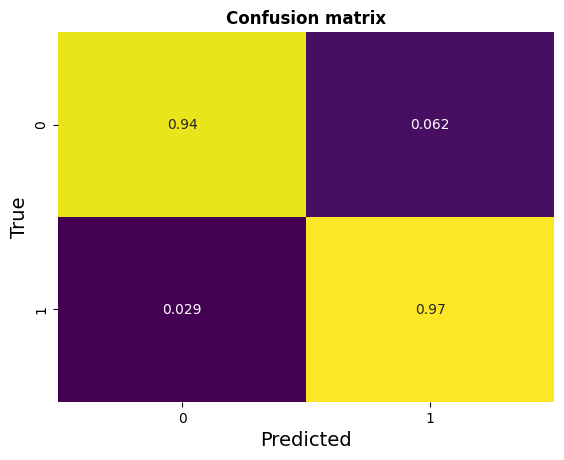

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

Predicted Labels:
 [1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1]
Probabilities:
 [0.7309791  0.7309919  0.7310141  0.7309244  0.73100066 0.7291861
 0.73101836 0.7310572  0.73105824 0.7239281  0.731022   0.6557027
 0.63176244 0.7310576  0.731054   0.7306617  0.7310549  0.7270088
 0.73103446 0.7309795  0.73104066 0.73102754 0.73104435 0.7310272
 0.73105603 0.725458   0.7310508  0.5597982  0.7310555  0.62729245
 0.73094577 0.7310509 ]
True Labels:
 [1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1]


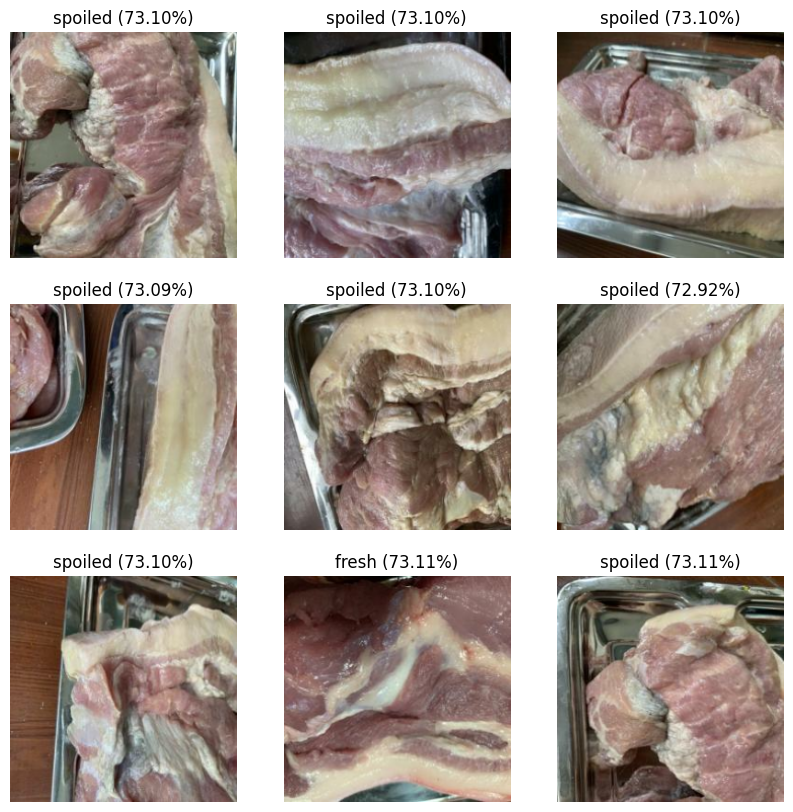

In [25]:
#Let test final model
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax activation
predictions = tf.nn.softmax(predictions)

# Get the predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get the probabilities for the predicted classes
probabilities = tf.reduce_max(predictions, axis=1)

print('Predicted Labels:\n', predicted_labels.numpy())
print('Probabilities:\n', probabilities.numpy())
print('True Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("{} ({:.2f}%)".format(class_names[predicted_labels[i]], probabilities[i] * 100))
    plt.axis("off")


In [26]:
model.save('lastmodel.h5')

In [27]:
#Let Test using exported model HDF5
import tensorflow as tf
from PIL import Image
import numpy as np

def classify(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    #image = np.array(image) / 255.0  # Normalize image

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)[0]
    probabilities = tf.reduce_max(predictions, axis=1)

    class_names = ['fresh', 'spoiled']  
    predicted_class = class_names[predicted_label]

    print('Predicted Class:', predicted_class)
    print('Probabilities:\n', probabilities.numpy())

# Assuming you have already loaded and compiled your TensorFlow model
model = tf.keras.models.load_model('lastmodel.h5')

# Example usage
#image_path = '/content/test/fresh/FRESH-100-_JPG_jpg.rf.ffb9ad8dd76de39c9ff0975019be2879.jpg' #fresh 
image_path = "fresh/FRESH-1000-_JPG.rf.d0f18a5c4075b50beeb7ee99036d491d.jpg" #spoiled
# image_path = "/content/test/spoiled/SPOILED-21-_JPG_jpg.rf.e97d5e008d43f0eec8ecc8f194221c9d.jpg" #spoiled
#image_path = "/content/test/fresh/FRESH-233-_JPG_jpg.rf.d3e77ac3424b7a3ffa3881b8f364067d.jpg" #fresh
classify(model, image_path)


1/1 [==============================] - 0s 479ms/step
Predicted Class: fresh
Probabilities:
 [0.9855913]
